In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import numpy as np
from PIL import Image


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


In [8]:
from subprocess import check_output
print(check_output(["ls", "../datasets/azm"]).decode("utf8"))

IM-0007-0001-0001.dcm
IM-0007-0001-0002.dcm
IM-0007-0002-0001.dcm
IM-0007-0002-0002.dcm
IM-0008-0080.dcm
IM-0008-0081.dcm
IM-0008-0082.dcm
IM-0008-0083.dcm
IM-0008-0084.dcm
IM-0008-0085.dcm
IM-0008-0086.dcm
IM-0008-0087.dcm
IM-0008-0088.dcm
IM-0008-0089.dcm
IM-0008-0090.dcm
IM-0008-0091.dcm
IM-0008-0092.dcm
IM-0008-0093.dcm
IM-0008-0094.dcm
IM-0008-0095.dcm
IM-0008-0096.dcm
IM-0008-0097.dcm
IM-0008-0098.dcm
IM-0008-0099.dcm
IM-0008-0100.dcm
IM-0008-0101.dcm
IM-0008-0102.dcm
IM-0008-0103.dcm
IM-0008-0104.dcm
IM-0008-0105.dcm
IM-0008-0106.dcm
IM-0008-0107.dcm
IM-0008-0108.dcm
IM-0008-0109.dcm
IM-0008-0110.dcm
IM-0008-0111.dcm
IM-0008-0112.dcm
IM-0008-0113.dcm
IM-0008-0114.dcm
IM-0008-0115.dcm
IM-0008-0116.dcm
IM-0008-0117.dcm
IM-0008-0118.dcm
IM-0008-0119.dcm
IM-0008-0120.dcm
IM-0008-0121.dcm
IM-0008-0122.dcm
IM-0008-0123.dcm
IM-0008-0124.dcm
IM-0008-0125.dcm
IM-0008-0126.dcm
IM-0008-0127.dcm
IM-0008-0128.dcm
IM-0008-0129.dcm
IM-0008-0130.dcm
IM-0008-0131.dcm
IM-0008-0132.dcm
IM-0008-013

Each CT Scan consists of multiple 2D slices which are provided in a DICOM format. At first, I will read the random dicom file of a CT Scan. After reading the image file, we will update the intensity values of -2000 with 0 because they are the pixels that fall outside of the scanner bounds.

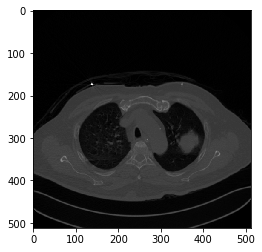

In [9]:
# Any results you write to the current directory are saved as output.
lung = dicom.read_file('../datasets/azm/IM-0008-0241.dcm')

slice = lung.pixel_array
slice[slice == -2000] = 0
plt.imshow(slice, cmap=plt.cm.gray)

In [4]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

In [7]:
ct_scan = read_ct_scan('../datasets/azm/') 

To visualise the slices, we will have to plot them. `matplotlib` is used for plotting the slices. The `plot_ct_scan` function takes a 3D CT Scanned Image array  as input and plots equally spaced slices. The CT Scans are grayscale images i.e. the value of each pixel is a single sample, which means it carries only intensity information.

In [13]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 40) + 1, 4, figsize=(30, 30))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 40), int((i % 20) / 5)].axis('off')
        plots[int(i / 40), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

In [14]:
len(ct_scan)

1102

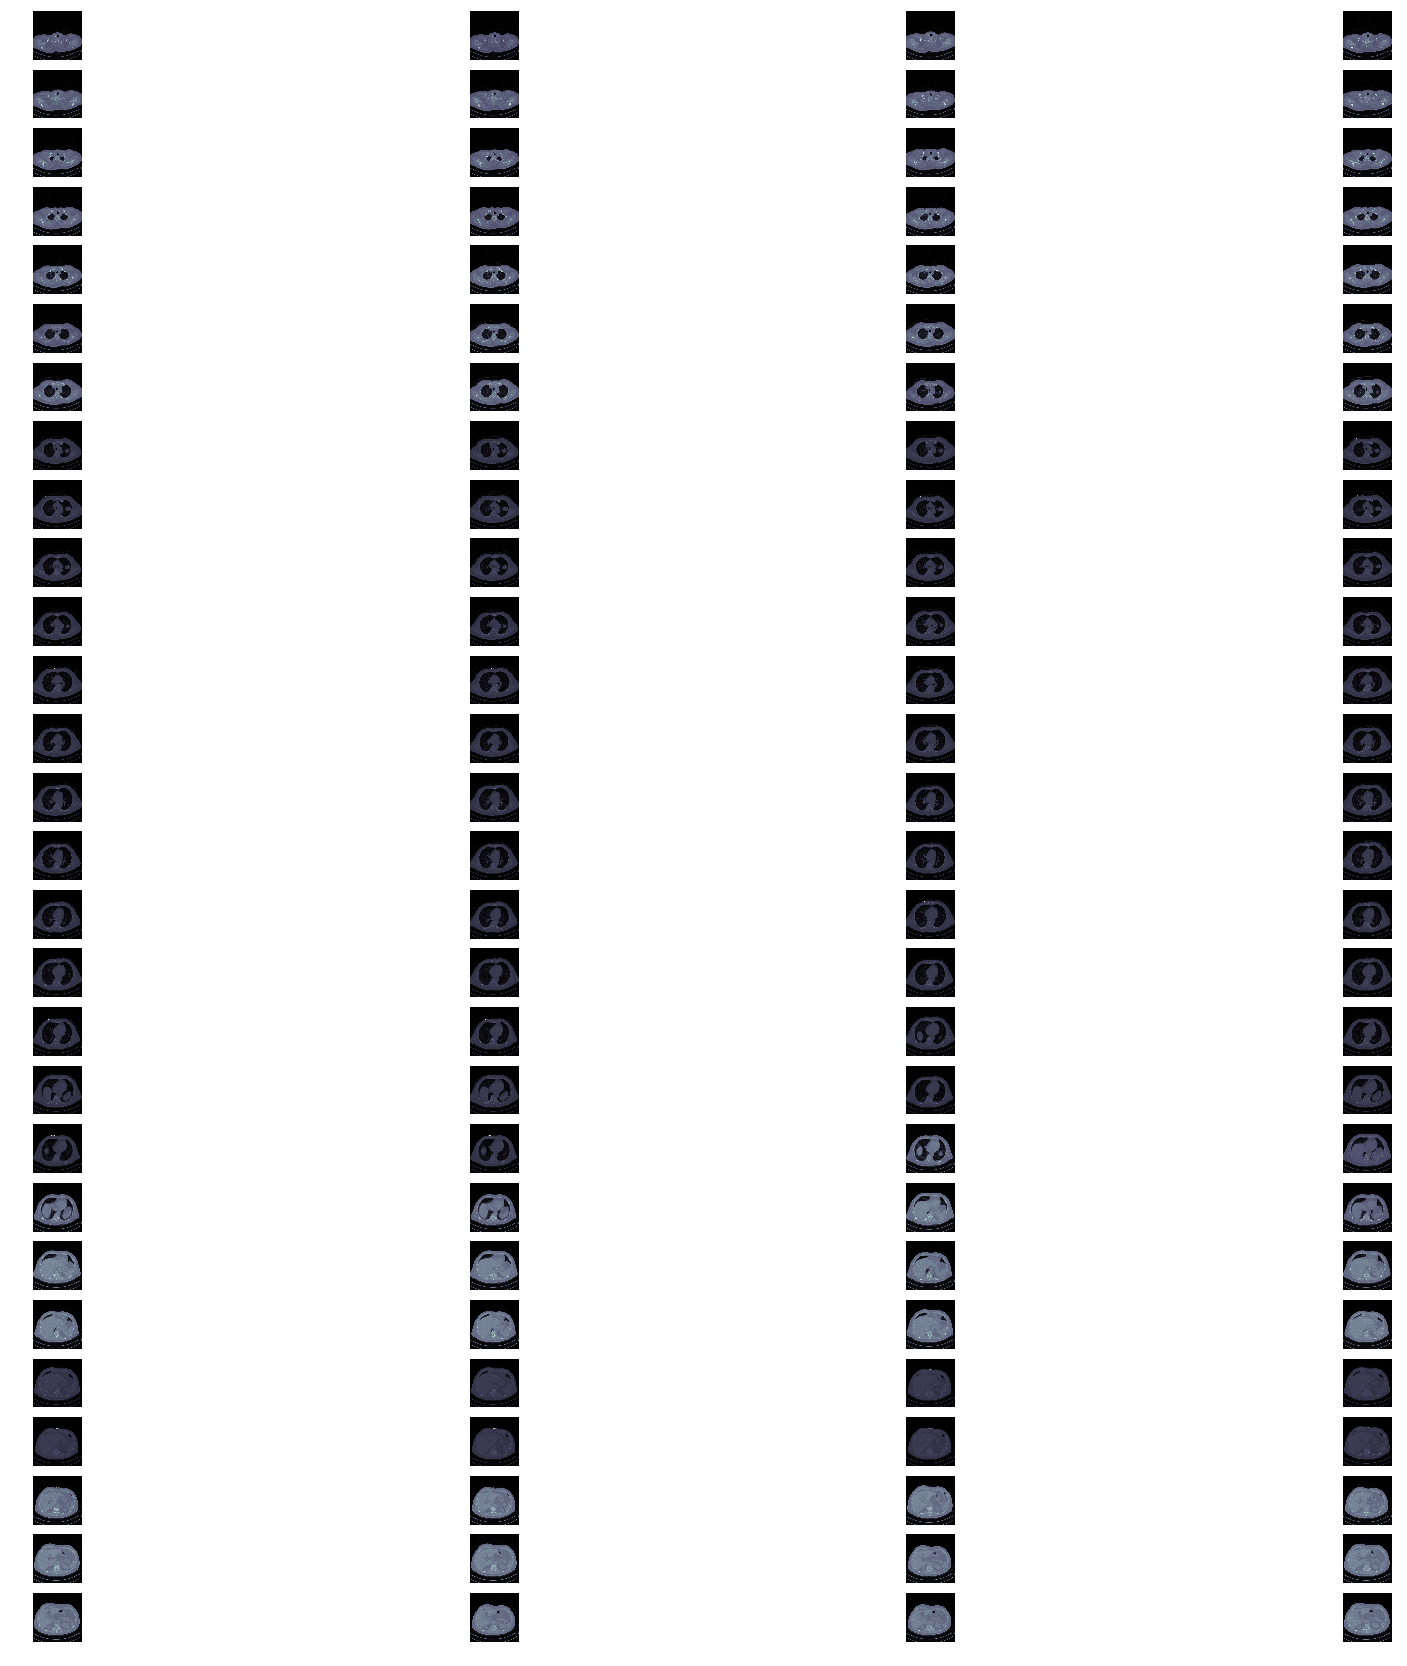

In [15]:
plot_ct_scan(ct_scan)

## Segmentation of Lungs ##
After reading the CT Scan, the first step in preprocessing is the segmentation of lung structures because it is obvious that the regions of interests lies inside the lungs. It is visible that the lungs are the darker regions in the CT Scans. The bright region inside the lungs are the blood vessels or air. A threshold of 604(-400 HU) is used at all places because it was found in experiments that it works just fine. We segment lung structures from each slice of the CT Scan image and try not to loose the possible region of interests attached to the lung wall. There are some nodules which may be attached to the lung wall.

I will first explain a common method using simple Image Processing and Morphological operations to segment the lungs and then will give references and summaries to good links of papers. 

In [16]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

The `get_segmented_lungs` function segments a 2D slice of the CT Scan. I have outputted the slice after all steps for better visualisation and understanding of the code and applied operations.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

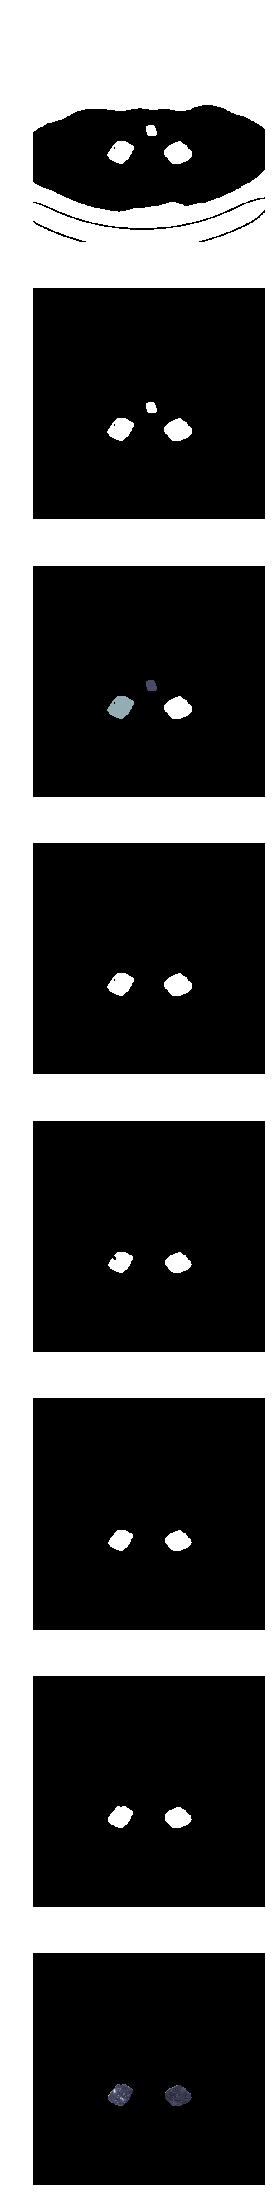

In [18]:
get_segmented_lungs(ct_scan[120], True)

Now, I will segment the whole CT Scan slice by slice and show some slices of the CT Scan.

In [19]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

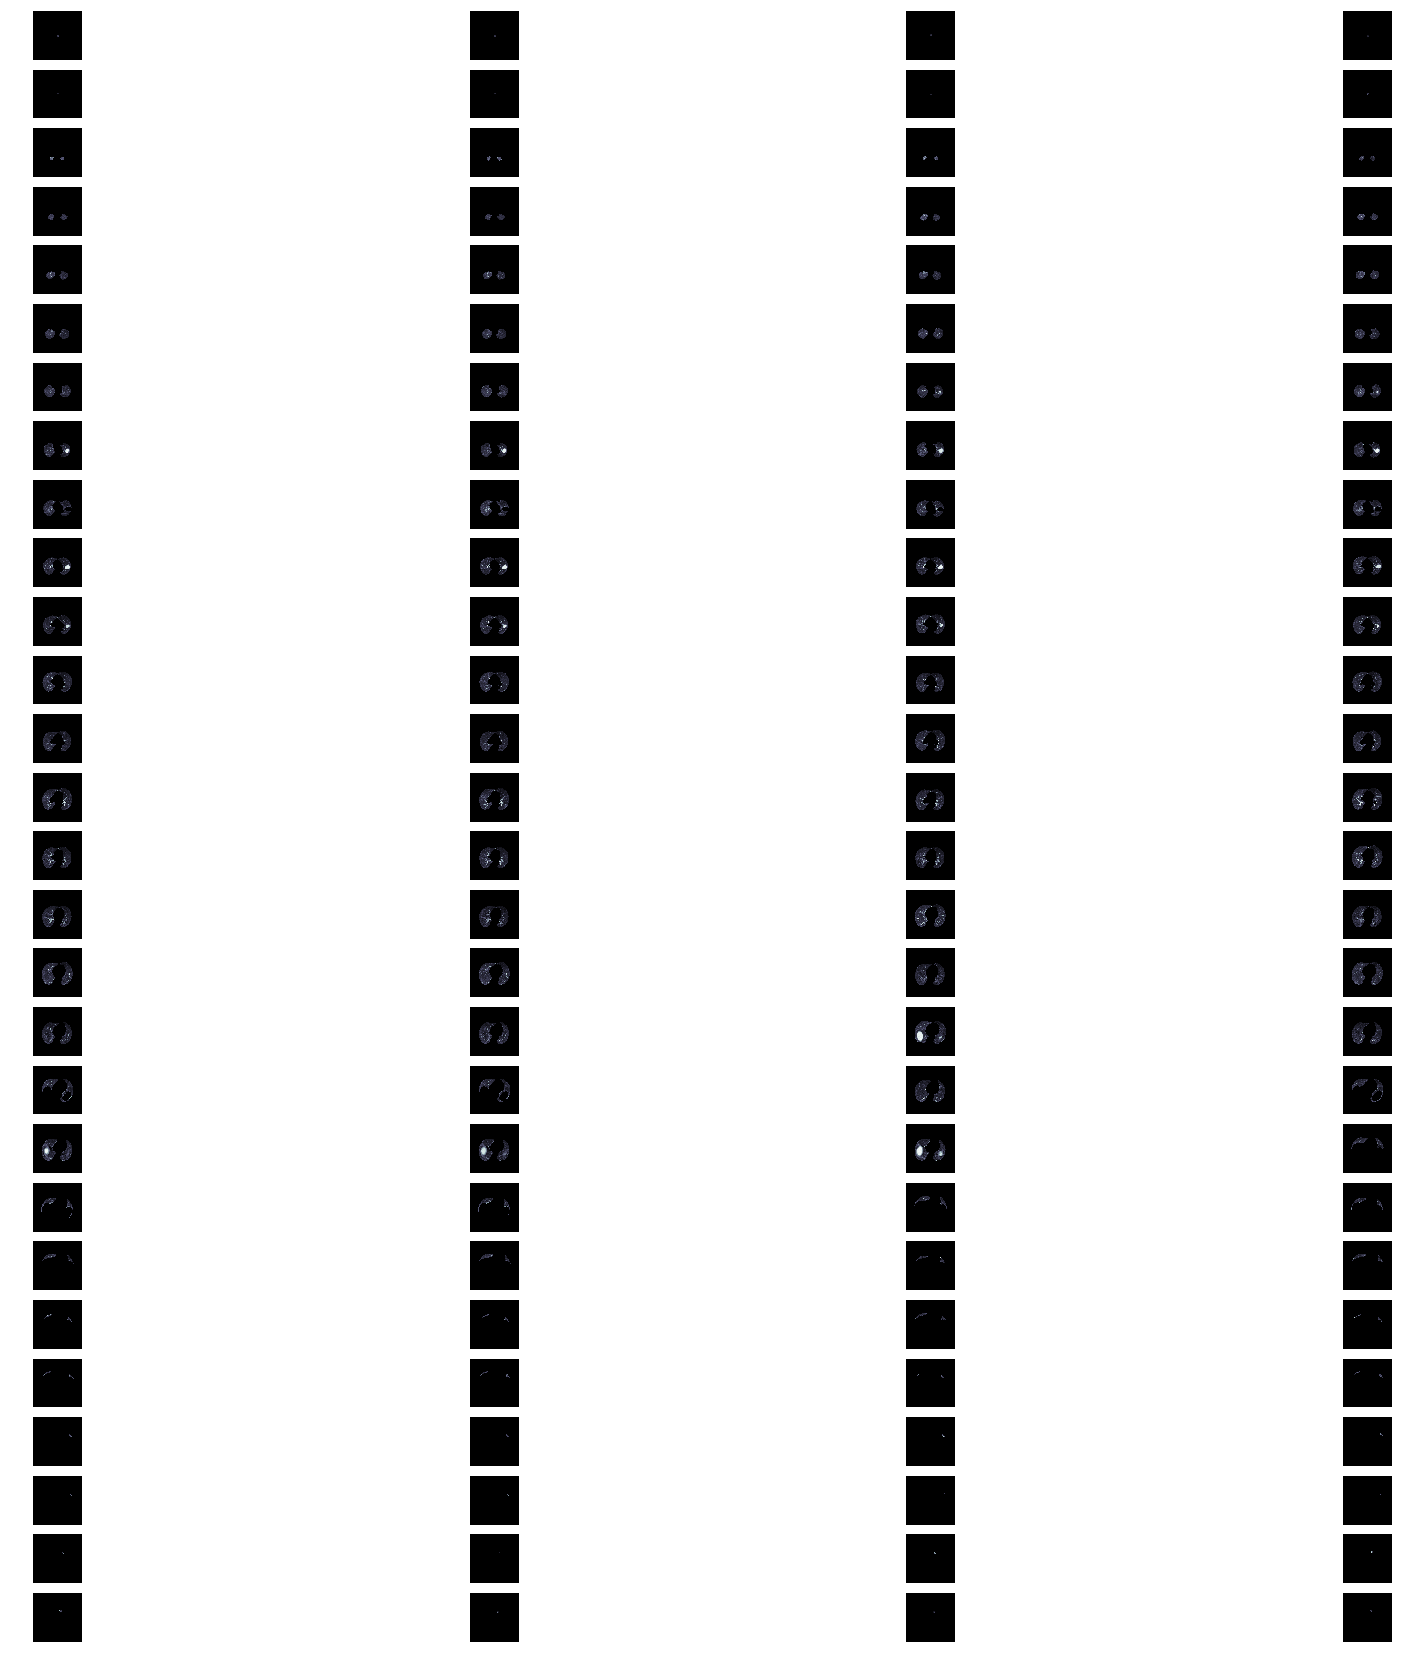

In [20]:
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
plot_ct_scan(segmented_ct_scan)

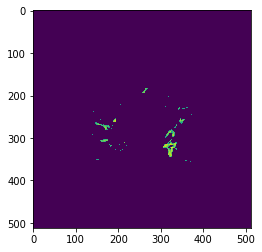

In [38]:
plt.imshow(segmented_ct_scan[550])

Nodule Candidate/Region of Interest Generation
---------------------------
After segmenting the lung structures from the CT Scanned images, our task is to find the candidate regions with nodules since the search space is very large. Also, whole image can't be classified directly using 3D CNNs due to limit on computation, we need to find possible regions of cancer and then classify them. It was found in experiments that all the region of interests have intensity >  604(-400 HU). So, we used this threshold to filter the darker regions. This reduces the number of candidates by a large number and preserves all the important regions with high recall. We then classify all the candidate points to reduce the False Positives.

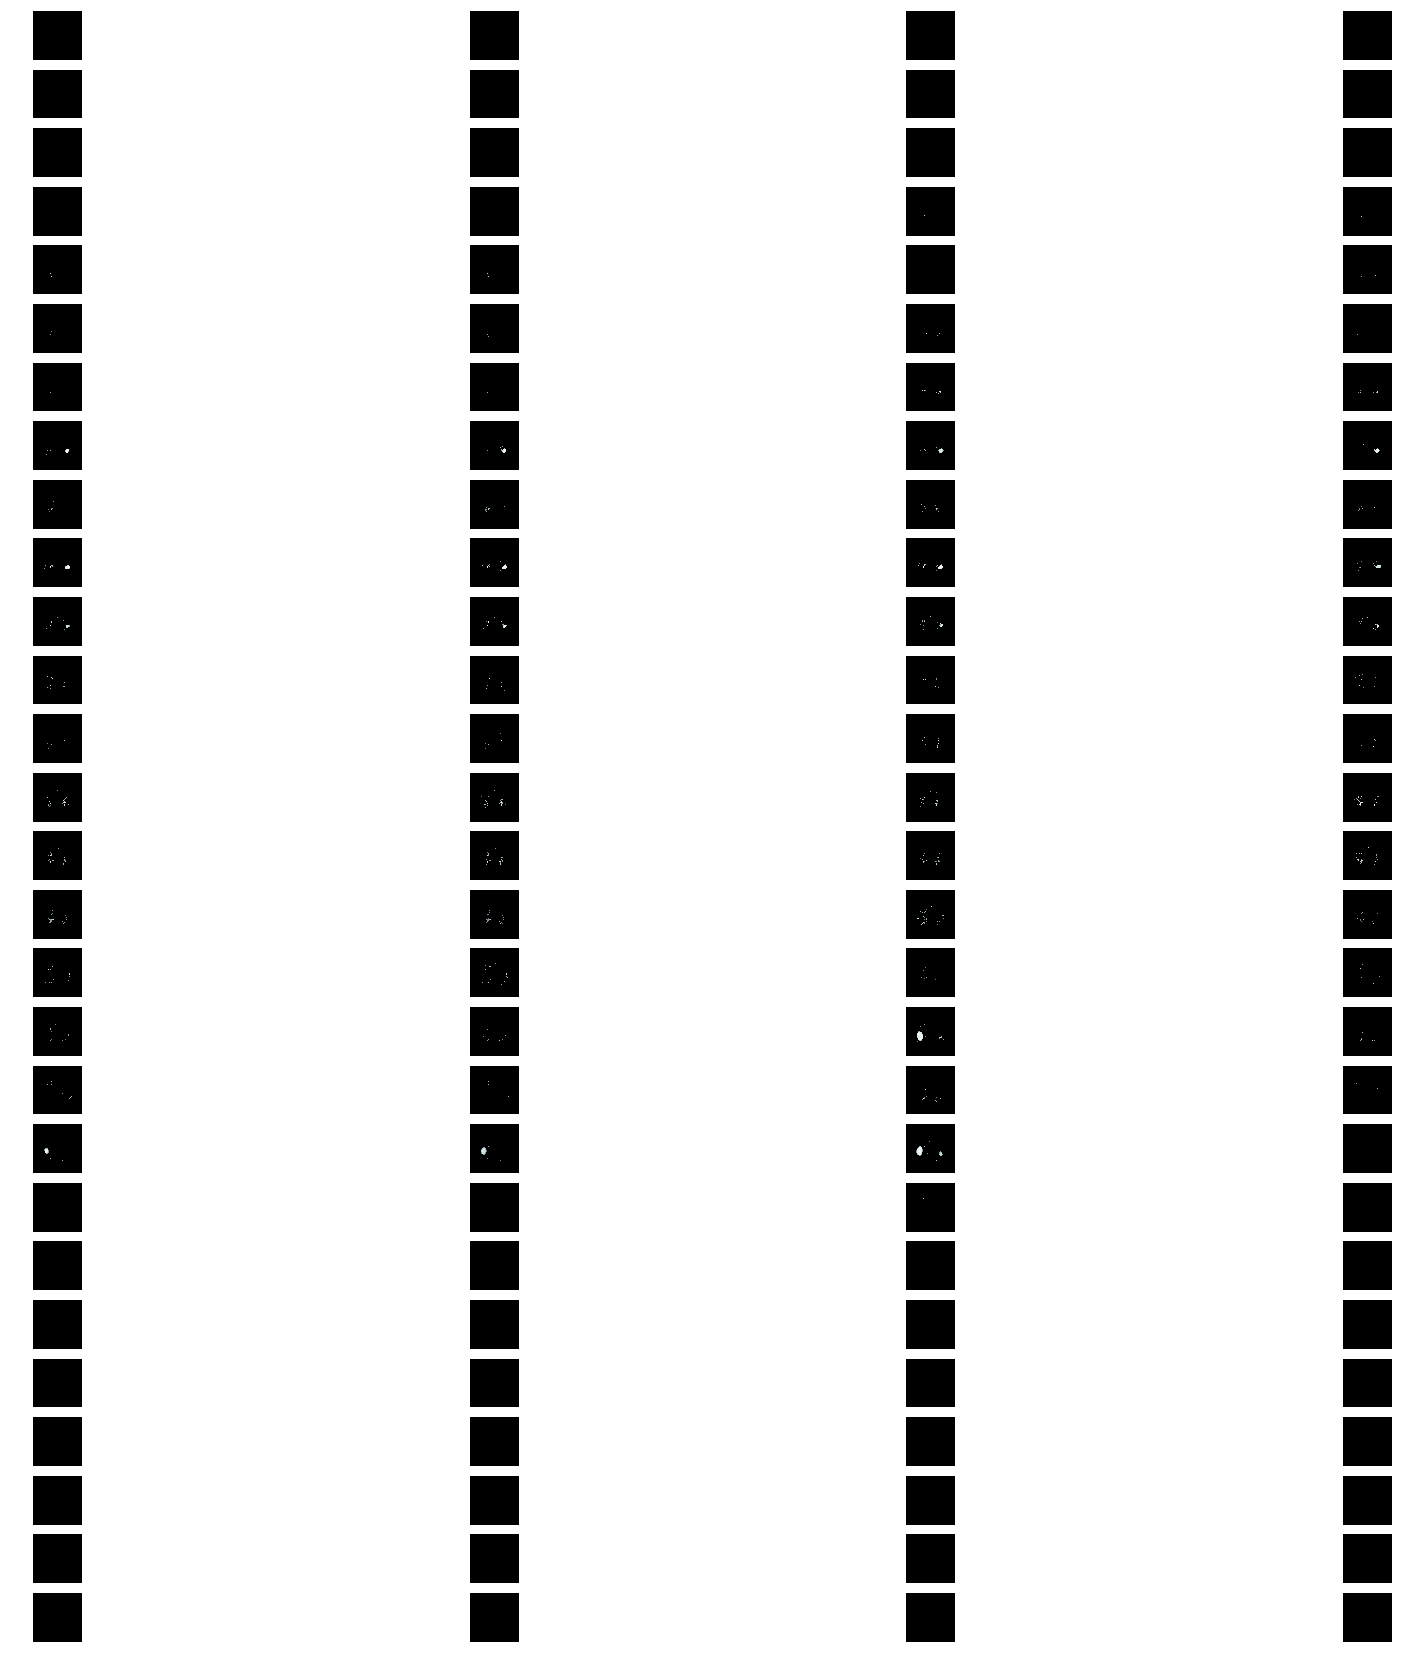

In [23]:
segmented_ct_scan[segmented_ct_scan < 604] = 0
plot_ct_scan(segmented_ct_scan)

After filtering, there are still lot of noise because of blood vessels. Thus we further remove the two largest connected component.

In [41]:
im = Image.fromarray(segmented_ct_scan[550])
im.mode = 'I'
im.point(lambda i:i*(1./256)).convert('L').save('../datasets/test.jpeg')
plt(im)

TypeError: 'module' object is not callable